# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Import-data" data-toc-modified-id="Import-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data</a></div><div class="lev2 toc-item"><a href="#School-District-Boundaries" data-toc-modified-id="School-District-Boundaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>School District Boundaries</a></div><div class="lev2 toc-item"><a href="#City-Boundaries" data-toc-modified-id="City-Boundaries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>City Boundaries</a></div><div class="lev2 toc-item"><a href="#Sales" data-toc-modified-id="Sales-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Sales</a></div><div class="lev2 toc-item"><a href="#Parcel-geolocation" data-toc-modified-id="Parcel-geolocation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Parcel geolocation</a></div><div class="lev2 toc-item"><a href="#Covariates" data-toc-modified-id="Covariates-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Covariates</a></div><div class="lev1 toc-item"><a href="#Projection" data-toc-modified-id="Projection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Projection</a></div><div class="lev1 toc-item"><a href="#Map-of-school-districts" data-toc-modified-id="Map-of-school-districts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Map of school districts</a></div><div class="lev1 toc-item"><a href="#Merge-sales,-covariates,-and-parcel-data" data-toc-modified-id="Merge-sales,-covariates,-and-parcel-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Merge sales, covariates, and parcel data</a></div><div class="lev2 toc-item"><a href="#Missing-data" data-toc-modified-id="Missing-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Missing data</a></div><div class="lev1 toc-item"><a href="#Plotting-house-sales-in-Tucson" data-toc-modified-id="Plotting-house-sales-in-Tucson-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting house sales in Tucson</a></div><div class="lev1 toc-item"><a href="#Attach-school-district-to-each-sale" data-toc-modified-id="Attach-school-district-to-each-sale-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Attach school district to each sale</a></div><div class="lev1 toc-item"><a href="#Borders" data-toc-modified-id="Borders-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Borders</a></div><div class="lev2 toc-item"><a href="#Example" data-toc-modified-id="Example-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Example</a></div><div class="lev2 toc-item"><a href="#Automate" data-toc-modified-id="Automate-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Automate</a></div><div class="lev1 toc-item"><a href="#Export" data-toc-modified-id="Export-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Export</a></div>

Merge the sales data with the parcel location data to get geocoded sales data, to be used to build our Spatial RDD example.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# plt.rc("figure", autolayout=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
from simpledbf import Dbf5
plot_dataframe = gpd.plotting.plot_dataframe

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [3]:
import shapely
from shapely.geometry import Point, LineString, MultiLineString, MultiPoint

# Import data

## School District Boundaries

In [4]:
schdistrs=gpd.read_file("national_data/Tiger/tlgdb_2015_a_us_school.gdb/a00000009.gdbtable")

## City Boundaries

In [5]:
cities=gpd.read_file("national_data/Place_2010Census_DP1/Place_2010Census_DP1.shp").to_crs(schdistrs.crs)

## Sales

In [6]:
tucson_sales_yearly=[]
for year in range(2011,2016):
    tucson_sales_yearly.append(pd.read_csv("Tucson_data/Sales/Sale%d.csv" % year,
        dtype={"SaleDate": str, "SequenceNum": str, "SalePrice": str}
    ))

In [29]:
tucson_sales=pd.concat(tucson_sales_yearly).set_index("Parcel")

## Parcel geolocation

In [8]:
adparcel=gpd.read_file("Tucson_data/adparcel/adparcel.shp")
adparcel.set_index("PARCEL", inplace=True)

In [9]:
print(adparcel.columns)

Index(['ADDRESS', 'ADPARCEL_', 'ADPARCEL_I', 'ADR_ID', 'AD_STREET',
       'AD_SUFFIX', 'ANGLE', 'AREA', 'CITY_ID', 'CODE', 'DATE_ENTER', 'LAT',
       'LON', 'PERIMETER', 'POLYGONID', 'SCALE', 'SOURCE', 'STATUS', 'STREET',
       'STREET_DIR', 'STREET_IDX', 'STREET_NAM', 'STREET_NO', 'SUFFIX_DIR',
       'TILE_NAME', 'X_HPGN', 'Y_HPGN', 'ZIPCITY', 'ZIPCODE', 'geometry'],
      dtype='object')


## Covariates

In [10]:
mas10=Dbf5("Tucson_data/Residential/MAS2010.DBF").to_dataframe()
mas11=Dbf5("Tucson_data/Residential/MAS2011.DBF").to_dataframe()
mas10.head()

,TAXYEAR,PARCEL,SFRCONDO,COMPLEXID,INSPECTION,CLASS,STORIES,ROOMS,QUALITY,WALLS,...,GARAGECAPA,POOLAREA,MAIN,CONTROL,ACTUAL,LASTACTION,VALUATIONC,APPLICATIO,ENHANCEMEN,ADJUSTMENT
0,2010.0,101013820,S,9999.0,1993-08-01,4.0,1.0,8.0,2.0,6.0,...,2.0,512.0,273202.0,273202.0,252165.0,19890626,00,0112,0.0,1.0
1,2010.0,101013850,S,9999.0,2007-09-01,4.0,1.0,7.0,2.0,6.0,...,4.0,0.0,229882.0,229882.0,212181.0,20080111,00,0112,0.0,1.0
2,2010.0,101013860,S,9999.0,1979-07-01,4.0,1.0,6.0,2.0,6.0,...,2.0,0.0,217171.0,217171.0,200449.0,19790928,00,0112,0.0,1.0
3,2010.0,101013890,S,9999.0,1985-09-01,4.0,1.0,7.0,2.0,6.0,...,2.0,0.0,251313.0,251313.0,231962.0,19851030,00,0112,0.0,1.0
4,2010.0,101013910,S,9999.0,2002-11-01,4.0,1.0,8.0,2.0,6.0,...,2.0,512.0,276276.0,276276.0,255003.0,20021204,00,0112,3000.0,1.0


In [11]:
mas14=pd.read_csv("Tucson_data/Residential/Mas14.csv", dtype={"VALUATIONC":"S3"})
mas16=pd.read_csv("Tucson_data/Residential/Mas16.csv", dtype={"VALUATIONC":"S3"})
mas17=pd.read_csv("Tucson_data/Residential/Mas17.csv", dtype={"VALUATIONC":"S3"})

In [12]:
print(len(set(mas10.PARCEL).intersection(set(mas16.PARCEL))), "parcels in both 2010 and 2016")
print(len(set(mas10.PARCEL).difference(set(mas16.PARCEL))), "parcels in 2010 not 2016")
print(len(set(mas16.PARCEL).difference(set(mas10.PARCEL))), "parcels in 2016 not 2010")
print(len(set(mas14.PARCEL).difference(set(mas16.PARCEL))), "parcels in 2014 not 2016")
print(len(set(mas17.PARCEL).difference(set(mas16.PARCEL))), "parcels in 2017 not 2016")

271818 parcels in both 2010 and 2016
2407 parcels in 2010 not 2016
13573 parcels in 2016 not 2010
786 parcels in 2014 not 2016
2085 parcels in 2017 not 2016


In [13]:
mas16.columns

Index(['TAXYEAR', 'PARCEL', 'SFRCONDO', 'COMPLEXID', 'INSPECTION', 'CLASS',
       'STORIES', 'ROOMS', 'QUALITY', 'WALLS', 'ROOF', 'HEAT', 'COOL',
       'BATHFIXTUR', 'PATIO', 'PATIONUMBE', 'CONDITION', 'SQFT', 'YEAR',
       'GARAGE', 'GARAGECAPA', 'POOLAREA', 'MAIN', 'CONTROL', 'ACTUAL',
       'LASTACTION', 'VALUATIONC', 'APPLICATION', 'ENHANCEMEN', 'ADJUSTMENT',
       'APPRAISER', 'PHONE'],
      dtype='object')

Some columns are integer levels of factors that have corresponding labels, which are available online. Let's replace those columns with categorical columns to make data manipulation and interpretation more intuitive.

In [14]:
# from http://www.asr.pima.gov/downloads/pages/layout.aspx?tbl=MAS&year=2015
mas16_codes = {
    "Class": dict(enumerate(["LM","R-1","R-2","R-3","R-4","R-5","R-6"],0)),
    "Quality": dict(enumerate(["Minimum","Fair","Good","Excellent"],1)),
    "Walls": dict(enumerate(["Framed Wood","Framed Block","8 inch Painted","8 inch Stucco",
              "Brick","Stone","SlumpBlock","Adobe","Other"], 0)),
    "Roof": dict(enumerate(["Wood","Asphalt","Asbestos","Built Up",
                            "Tile","Slate","Metal","Prepared Roll","Other"], 0)),
    "Heat": dict(enumerate(["Gravity","Forced","Steam","Hot Water","Radiant","Floor Furnance" # [sic]
             ,"Wall Furnance", "Electric Panel", "Other", "None"], 0)),
    "Cool": {0: "Refrigeration",1:"Evaporative",2:"Wall",9:"None"},
    "Patio": {1:"Slab",3:"Covered",6:"Covered Slab (both)",9:"None"},
#     "Condition": dict(enumerate(["Minimum","Fair","Good","Excellent"],1)), # doesn't seem to be accurate
    "Garage": {1:"Garage",3:"Carport",6:"Garage & Carport (both)",9:"None"},
}

In [15]:
set(mas16["CONDITION"])

{0, 1, 2, 3, 4, 6}

In [16]:
for key, labels_dict in mas16_codes.items():
    print(key)
    col=mas16[key.upper()]
    cat=pd.Categorical(col)
    new_labels=[labels_dict[k] for k in cat.categories]
    cat.rename_categories(new_labels, inplace=True)
    mas16[key.upper()] = cat
for key, labels_dict in mas16_codes.items():
    print(key)
    col=mas17[key.upper()]
    cat=pd.Categorical(col)
    new_labels=[labels_dict[k] for k in cat.categories]
    cat.rename_categories(new_labels, inplace=True)
    mas17[key.upper()] = cat
print(mas16["GARAGE"].value_counts())
print(mas17["GARAGE"].value_counts())

Quality
Walls
Garage
Heat
Class
Patio
Roof
Cool
Quality
Walls
Garage
Heat
Class
Patio
Roof
Cool
Garage                     166137
Carport                     74710
None                        40871
Garage & Carport (both)      3673
Name: GARAGE, dtype: int64
Garage                     168017
Carport                     74472
None                        40822
Garage & Carport (both)      3726
Name: GARAGE, dtype: int64


In [17]:
masAdds16=pd.read_csv("Tucson_data/Additions/MasAdds16.csv")
masAdds16.columns

Index(['TAXYEAR', 'PARCEL', 'BLDG_ID', 'SFRCONDO', 'OCCUPANCY', 'DETACHED',
       'CLASS', 'QUALITY', 'YEAR', 'SQFT', 'STORIES', 'HEAT', 'COOL', 'WALLS',
       'ROOF', 'GARAGE', 'GARAGECAPA', 'PATIO', 'PATIONUMBE', 'MAINFCV',
       'ENHANCEMEN', 'VALUATIONC', 'MAIN', 'ACTUAL', 'ADJUSTMENT'],
      dtype='object')

In [18]:
# from http://www.asr.pima.gov/downloads/pages/layout.aspx?tbl=MAS&year=2015
masAdds16_codes = {
    "SfrCondo": {"S": "Single Family Residence"},
    "Class": dict(enumerate(["LM","R-1","R-2","R-3","R-4","R-5","R-6"],0)),
    "Walls": dict(enumerate(["Framed Wood","Framed Block","8 inch Painted","8 inch Stucco",
              "Brick","Stone","SlumpBlock","Adobe","Other"], 0)),
    "Roof": dict(enumerate(["Wood","Asphalt","Asbestos","Built Up",
                            "Tile","Slate","Metal","Prepared Roll","Other"], 0)),
    "Heat": dict(enumerate(["Gravity","Forced","Steam","Hot Water","Radiant","Floor Furnance" # [sic]
             ,"Wall Furnance", "Electric Panel", "Other", "None"], 0)),
    "Cool": {0: "Refrigeration",1:"Evaporative",2:"Wall",9:"None"},
    "Patio": {1:"Slab",3:"Covered",6:"Covered Slab (both)",9:"None"},
#     "Condition": dict(enumerate(["Minimum","Fair","Good","Excellent"],1)), # doesn't seem to be accurate
    "Garage": {1:"Garage",3:"Carport",6:"Garage & Carport (both)",9:"None"},
}

In [19]:
for key, labels_dict in masAdds16_codes.items():
    print(key)
    col=masAdds16[key.upper()]
    cat=pd.Categorical(col)
    new_labels=[labels_dict[k] for k in cat.categories]
    cat.rename_categories(new_labels, inplace=True)
    masAdds16[key.upper()] = cat
masAdds16["GARAGE"].value_counts()

Walls
Patio
Heat
Garage
Class
Roof
SfrCondo
Cool


None                       6270
Garage                      467
Carport                     426
Garage & Carport (both)      28
Name: GARAGE, dtype: int64

In [21]:
land16=pd.read_csv("Tucson_data/Land/Land16.csv")
print(land16.size)
land16.head()

1051752


,PARCEL,LANDMEAS,LANDUNIT,LANDFCV,LUV,SOURCE,APPRAISER,PHONE
0,10101001D,16.31,A,195720,12000.00,E,Public Service,724-2767
1,10101002A,107755.00,F,542008,5.03,,Kevin B.,724-7403
2,10101003E,94577.00,F,1229501,13.00,,Donald B.,724-7426
3,10101003L,81009.00,F,810090,10.00,,Mark B.,724-7458
4,10101003M,60306.00,F,542754,9.00,,Mark B.,724-7458


# Projection

Ultimately, our Gaussian Process code will need x and y planar coordinates, with which distances between two points can be calculated as $\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$. Therefore we can't use raw longitudes and latitudes, they first need to be projected onto a Euclidian plane. Arizona has its own [coordinate system](https://www.webcms.pima.gov/cms/One.aspx?portalId=169&pageId=28222) that is a good choice for this task, and is associated with the [EPSG code 26749](http://www.spatialreference.org/ref/epsg/26749/). All we need to do is convert the coordinate reference system (CRS) of all our dataframes to EPSG 26749.

In [22]:
adparcel = adparcel.to_crs(epsg=26749)
schdistrs = schdistrs.to_crs(epsg=26749)
cities = cities.to_crs(epsg=26749)

In [23]:
print(adparcel.ix[0, "geometry"])
print(adparcel.ix[1, "geometry"])

POINT (936436.4682794245 553187.1136988925)
POINT (937315.5846172333 552895.5028526088)


Let's take a quick moment to check that the distances returned by the geopandas library can also be obtained via the simple Euclidian distance formula.

In [24]:
adparcel.geometry[0].distance(adparcel.geometry[1])

926.2194238260362

In [25]:
np.sqrt((936436.4682794245-937315.5846172333)**2+(553187.1136988925-552895.5028526088)**2)

926.21942382603618

# Map of school districts

In [26]:
def city_schdistrs(city):
    intersect = schdistrs[schdistrs.intersects(city)]
    areas = intersect.intersection(city).area
    # throw out districts that aren't at least a thousandth of the city's surface area
    nonzero_area = areas > (city.area/1000)
    return intersect[nonzero_area] 
    
def simplename(s):
    return (s
        .replace("District","")
        .replace("School","")
        .replace("Community","")
        .replace("Independent","")
        .replace("Unified","")
        .strip()
    )
def plot_city(city):
    plot_dataframe(city, color="white", linewidth=3)
    old_xlim = plt.xlim()
    old_ylim = plt.ylim()
    schdistrs = city_schdistrs(city.geometry.values[0])
    plot_dataframe(schdistrs, ax=plt.gca())
    plt.xlim(old_xlim[0]-0.1,old_xlim[1]+0.1)
    plt.ylim(old_ylim[0]-0.1,old_ylim[1]+0.1)

    for row in schdistrs.iterrows():
        name = row[1].NAME
        geom = row[1].geometry
        x = geom.centroid.x
        y = geom.centroid.y
        plt.text(np.clip(x,*plt.xlim()), np.clip(y,*plt.ylim()), simplename(name), horizontalalignment='center')

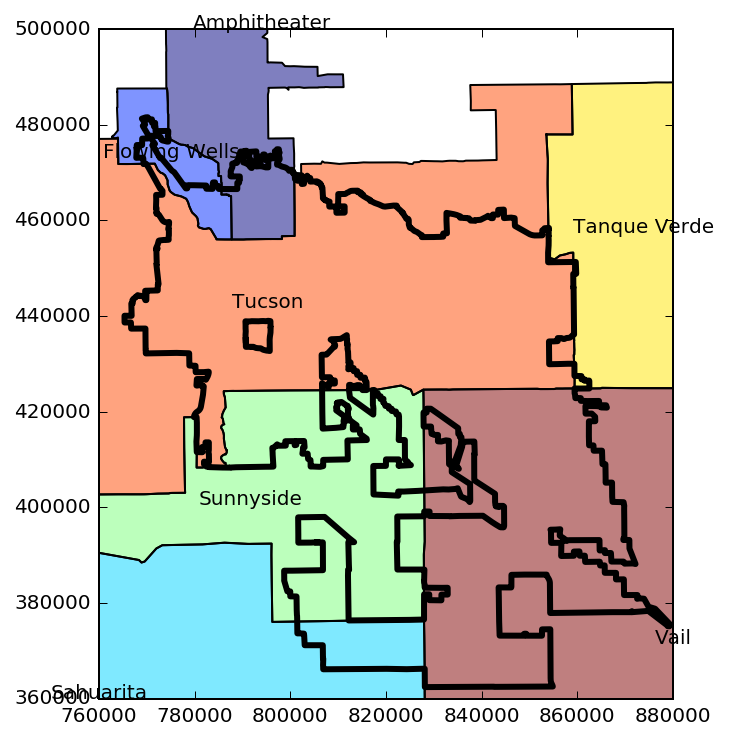

In [27]:
tucson=cities[cities.NAMELSAD10=="Tucson city"].iloc[0:1]
plot_city(tucson)

# Merge sales, covariates, and parcel data

In [30]:
TC_sales_geocoded=adparcel.join(tucson_sales, how="right")

Remove sales with no location (only 8311 sales are removed out of 114343, so no big deal).

In [31]:
notnan = np.logical_not(TC_sales_geocoded.geometry.isnull().values)
TC_sales_notnan = TC_sales_geocoded[notnan]
pd.Series(notnan).value_counts()

True     106032
False      8311
dtype: int64

In [32]:
in_tucson = TC_sales_notnan.within(tucson.geometry.values[0])

In [33]:
TC_sales_Tucson = TC_sales_notnan[in_tucson]
TC_sales_Tucson=TC_sales_Tucson.to_crs(tucson.crs)

Now merge in the covariates.

In [34]:
TC_sales_Tucson=TC_sales_Tucson.join(mas17.set_index("PARCEL"), how="left")
TC_sales_Tucson=TC_sales_Tucson.join(masAdds16.set_index("PARCEL"), how="left", rsuffix="Adds")

## Missing data

**Bad news:** a quarter of sales don't have associates square footage data.

In [35]:
pd.Series(np.isnan(TC_sales_Tucson.SQFT.values)).value_counts()

False    31374
True      9615
dtype: int64

In [36]:
print(np.isnan(TC_sales_Tucson.SQFT).mean(), "<- fraction of missing values")

0.234575129913 <- fraction of missing values


In [37]:
print(len(set(in_tucson[in_tucson.values].index.values).difference(set(mas16.PARCEL))), 
    "Tucson parcels missing in `mas16` dataset")
print(len(set(in_tucson[in_tucson.values].index.values).difference(set(mas17.PARCEL))), 
    "Tucson parcels missing in `mas17` dataset")

5859 Tucson parcels missing in `mas16` dataset
5512 Tucson parcels missing in `mas17` dataset


How can 9615 sales have missing square footage, but only 5512 parcels be missing from the `mas17` dataset? Well, for one thing, some parcels are repeatedly sold and account for many sales.

In [38]:
import collections
c=collections.Counter(in_tucson[in_tucson].index.values)
c.most_common(10)

[('10821328B', 119),
 ('128100530', 48),
 ('12212147B', 48),
 ('11205283G', 48),
 ('12703544A', 36),
 ('12212117A', 36),
 ('13419044A', 35),
 ('11307223A', 25),
 ('11301146Z', 24),
 ('133231430', 24)]

Let's have a closer look at sales with missing square footage. First of all many are commercial properties or vacant land, so will be filtered out when we focus on residential buildings.

In [39]:
nosqft=np.isnan(TC_sales_Tucson.SQFT.values)
TC_sales_Tucson.iloc[nosqft,:].PropertyType.value_counts()

Commercial/Industrial    2823
Vacant Land              2495
2-4 Plex                 1930
Apartment Building       1121
Mobile Home               424
Other                     381
Single Family             353
Condo/Townhouse            88
Name: PropertyType, dtype: int64

Let's have a closer look at single family houses:

In [40]:
TC_sales_Tucson[nosqft & (TC_sales_Tucson.PropertyType=="Single Family")]

,ADDRESS,ADPARCEL_,ADPARCEL_I,ADR_ID,AD_STREET,AD_SUFFIX,ANGLE,AREA,CITY_ID,CODE,...,GARAGEAdds,GARAGECAPAAdds,PATIOAdds,PATIONUMBEAdds,MAINFCV,ENHANCEMENAdds,VALUATIONCAdds,MAINAdds,ACTUALAdds,ADJUSTMENTAdds
10512058B,4007 N STONE AV,119886.0,279703.0,278946.0,STONE,AV,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106011260,608 E KNOX DR,122234.0,277308.0,276551.0,KNOX,DR,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106011260,606 E KNOX DR,122320.0,277220.0,276464.0,KNOX,DR,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10602491A,3775 N PASTIME PL,124382.0,275126.0,274368.0,PASTIME,PL,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10604044A,302 E PRINCE RD,127631.0,271817.0,271074.0,PRINCE,RD,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10604044A,3540 N FONTANA AV,127767.0,271671.0,270928.0,FONTANA,AV,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10604107A,315 E MOHAVE RD,130661.0,268739.0,268004.0,MOHAVE,RD,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10604107A,315 E MOHAVE RD,130661.0,268739.0,268004.0,MOHAVE,RD,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10604107B,317 E MOHAVE RD,130365.0,269039.0,268303.0,MOHAVE,RD,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10604107B,317 E MOHAVE RD,130365.0,269039.0,268303.0,MOHAVE,RD,0.0,0.0,TUC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
pd.set_option("display.max_columns",200)
pd.set_option("display.max_info_columns",200)
pd.set_option("display.max_rows",200)

The first house listed with parcel ID 10512058B has details available at http://www.asr.pima.gov/links/frm_AdvancedSearch_v2.aspx?search=Parcel . Why isn't it in in mas17? It's also not in the land dataset:

In [42]:
land16[land16.PARCEL=="10512058B"]

,PARCEL,LANDMEAS,LANDUNIT,LANDFCV,LUV,SOURCE,APPRAISER,PHONE


It turns out the problem was that the parcel was in lowercase in the mas datasets! Here is the data:

In [43]:
mas17[mas17.PARCEL=="10512058b"]

,TAXYEAR,PARCEL,SFRCONDO,COMPLEXID,INSPECTION,CLASS,STORIES,ROOMS,QUALITY,WALLS,ROOF,HEAT,COOL,BATHFIXTUR,PATIO,PATIONUMBE,CONDITION,SQFT,YEAR,GARAGE,GARAGECAPA,POOLAREA,MAIN,CONTROL,ACTUAL,LASTACTION,VALUATIONC,APPLICATION,ENHANCEMEN,ADJUSTMENT,APPRAISER,PHONE
15263,2017,10512058b,S,9999,Jul 1 1984 12:00AM,R-1,1.0,8,Minimum,Framed Wood,Prepared Roll,Other,Wall,6,Covered,3,1,1270,1935,Carport,1,0.0,61838,61838,61838,19841119,b'00',131,0,1.0,Steve A.,724-3055


But still no land data:

In [44]:
land16.PARCEL[land16.PARCEL>="10512058"].sort_values()[:1]

6152    10512058C
Name: PARCEL, dtype: object

In [45]:
TC_sales_Tucson = TC_sales_notnan[in_tucson]
TC_sales_Tucson=TC_sales_Tucson.to_crs(tucson.crs)
mas17.PARCEL=mas17.PARCEL.str.upper()
mas17.PARCEL=mas17.PARCEL.str.strip()
land16.PARCEL=land16.PARCEL.str.upper()
land16.PARCEL=land16.PARCEL.str.strip()
masAdds16.PARCEL=masAdds16.PARCEL.str.upper()
masAdds16.PARCEL=masAdds16.PARCEL.str.strip()
TC_sales_Tucson=TC_sales_Tucson.join(mas17.set_index("PARCEL"), how="left")
TC_sales_Tucson=TC_sales_Tucson.join(masAdds16.set_index("PARCEL"), how="left", rsuffix="Adds")
TC_sales_Tucson=TC_sales_Tucson.join(land16.set_index("PARCEL"), how="left", rsuffix="Land")

In [46]:
nosqft=np.isnan(TC_sales_Tucson.SQFT.values)
TC_sales_Tucson.iloc[nosqft,:].PropertyType.value_counts()

Commercial/Industrial    2823
Vacant Land              2495
2-4 Plex                 1930
Apartment Building       1121
Mobile Home               423
Other                     381
Single Family             339
Condo/Townhouse            88
Name: PropertyType, dtype: int64

Less progress than hoped! Still 339 (down from 353) single family homes with no square footage data. Let's look at the next one down.

In [47]:
TC_sales_Tucson[nosqft & (TC_sales_Tucson.PropertyType=="Single Family")]

,ADDRESS,ADPARCEL_,ADPARCEL_I,ADR_ID,AD_STREET,AD_SUFFIX,ANGLE,AREA,CITY_ID,CODE,DATE_ENTER,LAT,LON,PERIMETER,POLYGONID,SCALE,SOURCE,STATUS,STREET,STREET_DIR,STREET_IDX,STREET_NAM,STREET_NO,SUFFIX_DIR,TILE_NAME,X_HPGN,Y_HPGN,ZIPCITY,ZIPCODE,geometry,SequenceNum,SaleDate,SalePrice,PropertyType,IntendedUse,Deed,Financing,ValidationDescription,BuyerSellerRelated,Solar,PersonalProperty,PartialInterest,RecordingDate,TAXYEAR,SFRCONDO,COMPLEXID,INSPECTION,CLASS,STORIES,ROOMS,QUALITY,WALLS,ROOF,HEAT,COOL,BATHFIXTUR,PATIO,PATIONUMBE,CONDITION,SQFT,YEAR,GARAGE,GARAGECAPA,POOLAREA,MAIN,CONTROL,ACTUAL,LASTACTION,VALUATIONC,APPLICATION,ENHANCEMEN,ADJUSTMENT,APPRAISER,PHONE,TAXYEARAdds,BLDG_ID,SFRCONDOAdds,OCCUPANCY,DETACHED,CLASSAdds,QUALITYAdds,YEARAdds,SQFTAdds,STORIESAdds,HEATAdds,COOLAdds,WALLSAdds,ROOFAdds,GARAGEAdds,GARAGECAPAAdds,PATIOAdds,PATIONUMBEAdds,MAINFCV,ENHANCEMENAdds,VALUATIONCAdds,MAINAdds,ACTUALAdds,ADJUSTMENTAdds,LANDMEAS,LANDUNIT,LANDFCV,LUV,SOURCELand,APPRAISERLand,PHONELand
106011260,608 E KNOX DR,122234.0,277308.0,276551.0,KNOX,DR,0.0,0.0,TUC,0.0,2000-02-19,32.277340,-110.961876,0.0,122234.0,1.0,PC DSD GIS,S,E KNOX DR,E,KNOX,KNOX DR,608.0,None,E131325,995083.0,465939.0,TUCSON,85705,POINT (795289.5129142134 465897.0915009089),20132810309,201310,86900,Single Family,PrimaryRes,Warranty Deed,Other,Sale to or from a government agency,No,No,No,No,2013-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50,S,75000.0,50000.00,,Sheri P.,724-7404
106011260,606 E KNOX DR,122320.0,277220.0,276464.0,KNOX,DR,0.0,0.0,TUC,0.0,2000-02-19,32.277246,-110.961738,0.0,122320.0,1.0,PC DSD GIS,P,E KNOX DR,E,KNOX,KNOX DR,606.0,None,E131325,995125.0,465905.0,TUCSON,85705,POINT (795332.4482095664 465863.1550063341),20132810309,201310,86900,Single Family,PrimaryRes,Warranty Deed,Other,Sale to or from a government agency,No,No,No,No,2013-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50,S,75000.0,50000.00,,Sheri P.,724-7404
10602491A,3775 N PASTIME PL,124382.0,275126.0,274368.0,PASTIME,PL,0.0,0.0,TUC,0.0,2004-04-01,32.275124,-110.973851,0.0,124382.0,1.0,PC DSD GIS,P,N PASTIME PL,N,PASTI,PASTIME PL,3775.0,None,E131325,991389.0,465100.0,TUCSON,85705,POINT (791595.79397535 465058.0971639504),20151620069,201505,67500,Single Family,Rental,Warranty Deed,Cash,Unsecured Mobile Home,No,No,No,No,2015-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11140.00,F,55000.0,4.94,,June M.,724-8722
10604044A,302 E PRINCE RD,127631.0,271817.0,271074.0,PRINCE,RD,0.0,0.0,TUC,0.0,2000-02-19,32.271646,-110.967579,0.0,127631.0,1.0,PC DSD GIS,P,E PRINCE RD,E,PRINC,PRINCE RD,302.0,None,E131325,993338.0,463851.0,TUCSON,85705,POINT (793545.1499937968 463809.8167639998),20151970205,201507,100000,Single Family,Rental,Warranty Deed,Cash,Sale under duress,No,No,No,No,2015-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8100.00,F,48600.0,6.00,,Linda C.,724-7422
10604044A,3540 N FONTANA AV,127767.0,271671.0,270928.0,FONTANA,AV,0.0,0.0,TUC,0.0,2007-12-03,32.271517,-110.967553,0.0,127767.0,1.0,PC DSD GIS,S,N FONTANA AV,N,FONTA,FONTANA AV,3540.0,None,E131325,993347.0,463805.0,TUCSON,85705,POINT (793553.7730565509 463763.1927526806),20151970205,201507,100000,Single Family,Rental,Warranty Deed,Cash,Sale under duress,No,No,No,No,2015-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Let's investigate parcel 106011260. No residential covariates, but we do have land information for this one:

In [48]:
land16[land16.PARCEL=="106011260"]

,PARCEL,LANDMEAS,LANDUNIT,LANDFCV,LUV,SOURCE,APPRAISER,PHONE
6328,106011260,1.5,S,75000,50000.0,,Sheri P.,724-7404


Looking up the property on [asr.pima.gov](http://www.asr.pima.gov/links/frm_AdvancedSearch_v2.aspx?search=Parcel), residential characteristics aren't available there either, instead there is data on commercial characteristics. Maybe this property is being used commercially? This is odd, as it's also labeled as a primary residence. Furthermore, we have a sale recorded in October 2013 for \$86,900, described as a “Sale to or from a government agency”. In 2006 the same house sold for $205,000, so the low sale price is odd. It's not marked as a “partial interest” either, which I think might mean that only part of the property was purchased. It's also not marked as a “personal property”, but then again that's the case for the vast majority of sales, so I don't think that's hugely significant.

In [49]:
TC_sales_Tucson.ValidationDescription.value_counts()

Good Sale                                                                 18169
Buyer/Seller has an Out-Of-State Address                                   8826
Sale under duress                                                          5206
Sale to or from a government agency                                        3524
More than five (5) parcels being sold                                      2352
Buyer/Seller are related parties or corporate entities                      957
Sale price missing                                                          446
Sale of partial interest                                                    314
Improvements not yet on assessment roll                                     257
Unusable sale which does not fit any other reject codes                     226
Buyer/Seller is a Non-Profit institution                                    128
Property altered since date of sale                                         107
Property type/use code are not consisten

In [50]:
TC_sales_Tucson.PartialInterest.value_counts()

No     40690
Yes      299
Name: PartialInterest, dtype: int64

In [51]:
TC_sales_Tucson.PersonalProperty.value_counts()

No     40915
Yes       74
Name: PersonalProperty, dtype: int64

# Plotting house sales in Tucson

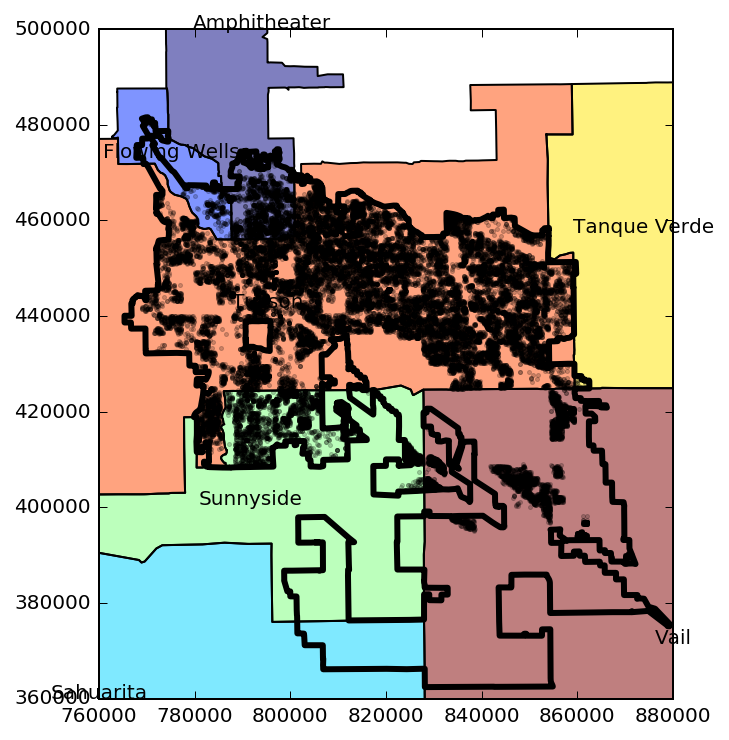

In [52]:
plot_city(tucson)
plot_dataframe(TC_sales_Tucson, ax=plt.gca(), color="black", alpha=0.2)

Each dot represents the sale of a property in 2015. The borders between school districts in the North-West part of the city look particularly promising. The border between Tucson Unified and Sunnyside Unified could also work. The long straight border between Tucson Unified and Vail Unified is unfortunately only populated on one side.

# Attach school district to each sale

In [53]:
tucson_schdistrs=city_schdistrs(tucson.geometry.values[0])
tucson_schdistrs

,ALAND,AWATER,GEOID,HIGRADE,INTPTLAT,INTPTLON,LOGRADE,NAME,SDTYP,geometry
198,2.824679e+08,535621.0,0400680,12,+32.4129772,-110.9635991,PK,Amphitheater Unified District,None,"(POLYGON ((773893.759044982 507678.4718737552,..."
217,3.098886e+07,496444.0,0403010,12,+32.2960635,-111.0258593,PK,Flowing Wells Unified District,None,"(POLYGON ((762769.28299846 477399.3870299263, ..."
263,1.574332e+09,377306.0,0407300,12,+31.8160529,-111.1075526,PK,Sahuarita Unified District,None,(POLYGON ((654819.5630310699 232333.8181122941...
273,2.504837e+08,0.0,0408170,12,+32.0979297,-110.9752480,PK,Sunnyside Unified District,None,(POLYGON ((716785.7785320296 402132.2473556149...
275,2.013622e+08,0.0,0408280,12,+32.2516572,-110.7076014,PK,Tanque Verde Unified District,None,(POLYGON ((853566.3010435958 477957.2288085489...
279,5.920991e+08,755055.0,0408800,12,+32.2114132,-110.9627656,PK,Tucson Unified District,None,"(POLYGON ((732295.8420664769 420816.086226508,..."
280,1.009159e+09,0.0,0408850,12,+32.0155294,-110.6873435,PK,Vail Unified District,None,"(POLYGON ((828027.0972032794 354217.043245537,..."


In [54]:
def get_ind(zones, point):
    ind=np.where(zones.contains(point))[0]
    if len(ind)==0:
        return None
    elif len(ind)>1:
        return None#np.argmin(zones.iloc[ind].area)
    return ind[0]

In [55]:
idistr=[get_ind(tucson_schdistrs, house) for house in TC_sales_Tucson.geometry]

In [56]:
sum([i is None for i in idistr])

0

In [57]:
TC_sales_Tucson["SchDistr"]=tucson_schdistrs.NAME.values[idistr]

# Borders

## Example

In [58]:
d1=tucson_schdistrs.geometry.values[0]
d2=tucson_schdistrs.geometry.values[1]

In [59]:
border=d1.intersection(d2)
assert isinstance(border, MultiLineString)

In [60]:
len(border.geoms)

325

In [61]:
max([l.length for l in border])

1675.6186810104182

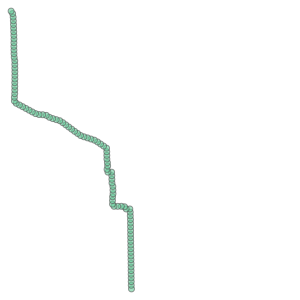

In [62]:
MultiPoint([border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])

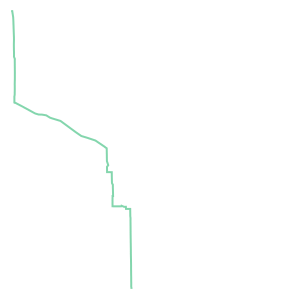

In [63]:
shapely.ops.linemerge(border.geoms)

## Automate

In [64]:
import itertools

In [65]:
ndistr = tucson_schdistrs.shape[0]
distr1_ls=[]
distr2_ls=[]
sentinels_ls=[]
borders_ls=[]

for i,j in itertools.combinations(range(ndistr),2):
    di = tucson_schdistrs.geometry.values[i]
    dj = tucson_schdistrs.geometry.values[j]
    distr_i = tucson_schdistrs.NAME.values[i]
    distr_j = tucson_schdistrs.NAME.values[j]
    border = di.intersection(dj)
    if not border.geoms:
        continue
#     assert isinstance(border, MultiLineString)
    merged_border = shapely.ops.linemerge(border)
    sentinels = MultiPoint([border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])
    sentinels_ls.append(sentinels)
    sentinels_ls.append(sentinels)
    borders_ls.append(merged_border)
    borders_ls.append(merged_border)
    distr1_ls.append(distr_i)
    distr1_ls.append(distr_j)
    distr2_ls.append(distr_j)
    distr2_ls.append(distr_i)

In [66]:
borders = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": borders_ls})
sentinels = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": sentinels_ls})

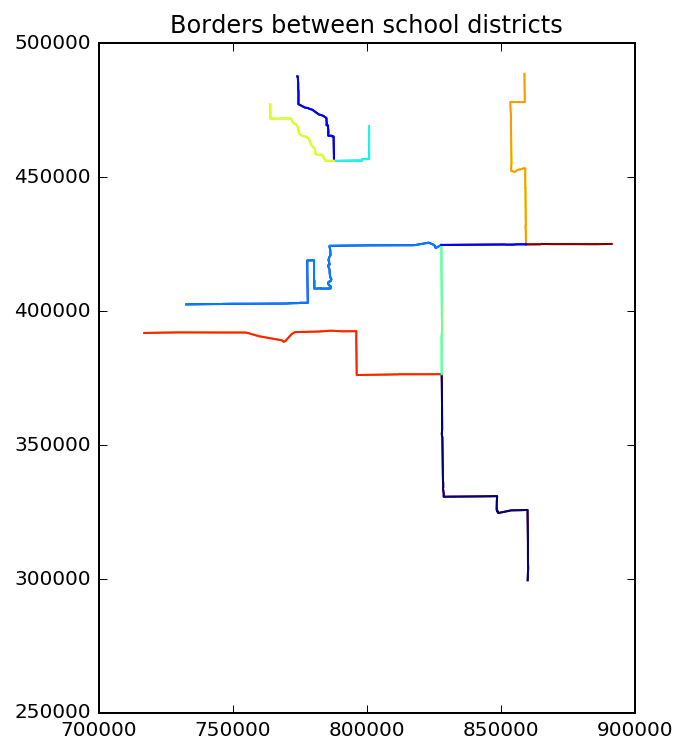

In [67]:
plot_dataframe(borders)
plt.title("Borders between school districts")

# Export

In [68]:
TC_sales_Tucson["X_PRJ"] = [p.x for p in TC_sales_Tucson.geometry.values]
TC_sales_Tucson["Y_PRJ"] = [p.y for p in TC_sales_Tucson.geometry.values]

In [69]:
TC_sales_Tucson.to_csv("Tucson_data/processed/Tucson_sales.csv")

In [70]:
borders.to_file('Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_borders.shp', driver='ESRI Shapefile')

In [71]:
sentinels.to_file('Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.shp', driver='ESRI Shapefile')

In [72]:
with open("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_borders.json", "w") as f:
    f.write(borders.to_json())

In [73]:
with open("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json", "w") as f:
    f.write(sentinels.to_json())